In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV

In [2]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish_D4_t_I7000_F9000/D4_t.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,100,7000,9000,400.35
1,0.0000,-0.00192,100,7000,9000,416.89
2,0.0000,-0.00184,100,7000,9000,432.05
3,0.0000,-0.00176,100,7000,9000,445.87
4,0.0000,-0.00168,100,7000,9000,458.33
...,...,...,...,...,...,...
43906,0.0024,0.00168,500,7000,9000,775.40
43907,0.0024,0.00176,500,7000,9000,715.43
43908,0.0024,0.00184,500,7000,9000,645.85
43909,0.0024,0.00192,500,7000,9000,585.87


In [3]:
df = data.drop(data.columns[3:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Zeitpunkt,Temperatur
0,0.0000,-0.00200,100,400.35
1,0.0000,-0.00192,100,416.89
2,0.0000,-0.00184,100,432.05
3,0.0000,-0.00176,100,445.87
4,0.0000,-0.00168,100,458.33
...,...,...,...,...
43906,0.0024,0.00168,500,775.40
43907,0.0024,0.00176,500,715.43
43908,0.0024,0.00184,500,645.85
43909,0.0024,0.00192,500,585.87


In [4]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Zeitpunkt  Temperatur
38620       0.00012      -0.00096        460     1229.80
14428       0.00108       0.00168        230      542.76
14359       0.00096       0.00024        230      777.04
21104       0.00168       0.00128        290      720.23
28698       0.00192       0.00088        360      886.28
...             ...           ...        ...         ...
6265        0.00204       0.00144        150      539.86
11284       0.00132      -0.00096        200      690.53
38158       0.00156      -0.00120        450     1049.80
860         0.00192       0.00152        100      464.69
15795       0.00180       0.00088        240      715.22

[43911 rows x 4 columns]


,X-Koordinate,Y-Koordinate,Zeitpunkt,Temperatur
0,0.00012,-0.00096,460,1229.80
1,0.00108,0.00168,230,542.76
2,0.00096,0.00024,230,777.04
3,0.00168,0.00128,290,720.23
4,0.00192,0.00088,360,886.28
...,...,...,...,...
43906,0.00204,0.00144,150,539.86
43907,0.00132,-0.00096,200,690.53
43908,0.00156,-0.00120,450,1049.80
43909,0.00192,0.00152,100,464.69


In [5]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [6]:
X

,X-Koordinate,Y-Koordinate,Zeitpunkt
0,0.00012,-0.00096,460
1,0.00108,0.00168,230
2,0.00096,0.00024,230
3,0.00168,0.00128,290
4,0.00192,0.00088,360
...,...,...,...
43906,0.00204,0.00144,150
43907,0.00132,-0.00096,200
43908,0.00156,-0.00120,450
43909,0.00192,0.00152,100


In [7]:
y

0        1229.80
1         542.76
2         777.04
3         720.23
4         886.28
          ...   
43906     539.86
43907     690.53
43908    1049.80
43909     464.69
43910     715.22
Name: Temperatur, Length: 43911, dtype: float64

In [8]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [9]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [10]:
X_train_scaled

array([[0.05 , 0.66 , 0.275],
       [0.8  , 0.02 , 0.525],
       [0.6  , 0.2  , 0.525],
       ...,
       [0.45 , 0.92 , 0.975],
       [0.3  , 0.7  , 0.875],
       [0.75 , 1.   , 0.275]])

In [11]:
y_train_scaled.max()

0.9999999999999999

In [12]:
# Netzwerkarchitektur
model = Sequential([

    Dense(136, activation='relu', input_shape=(3,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(168, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(24, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Trainingsparameter
batch_size = 75
epochs = 1000

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/1000
375/375 [==============================] - 2s 2ms/step - loss: 0.0657 - mae: 0.0700 - val_loss: 0.0465 - val_mae: 0.0349
Epoch 2/1000
375/375 [==============================] - 0s 1ms/step - loss: 0.0418 - mae: 0.0243 - val_loss: 0.0378 - val_mae: 0.0179
Epoch 3/1000
375/375 [==============================] - 0s 1ms/step - loss: 0.0348 - mae: 0.0170 - val_loss: 0.0319 - val_mae: 0.0132
Epoch 4/1000
375/375 [==============================] - 0s 1ms/step - loss: 0.0295 - mae: 0.0142 - val_loss: 0.0271 - val_mae: 0.0119
Epoch 5/1000
375/375 [==============================] - 0s 1ms/step - loss: 0.0251 - mae: 0.0123 - val_loss: 0.0231 - val_mae: 0.0107
Epoch 6/1000
375/375 [==============================] - 0s 1ms/step - loss: 0.0214 - mae: 0.0122 - val_loss: 0.0196 - val_mae: 0.0115
Epoch 7/1000
375/375 [==============================] - 0s 1ms/step - loss: 0.0180 - mae: 0.0106 - val_loss: 0.0165 - val_mae: 0.0100
Epoch 8/1000
375/375 [==============================] - 0s 1ms

In [13]:
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

275/275 - 0s - loss: 3.7289e-04 - mae: 0.0067 - 207ms/epoch - 753us/step


[0.00037289230385795236, 0.00668415566906333]

In [14]:
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")

 Bsp. Predicted: [602.8588] Actual: [596.74] 
Durchschnittliche Abweichung (MAE): [7.67562313]


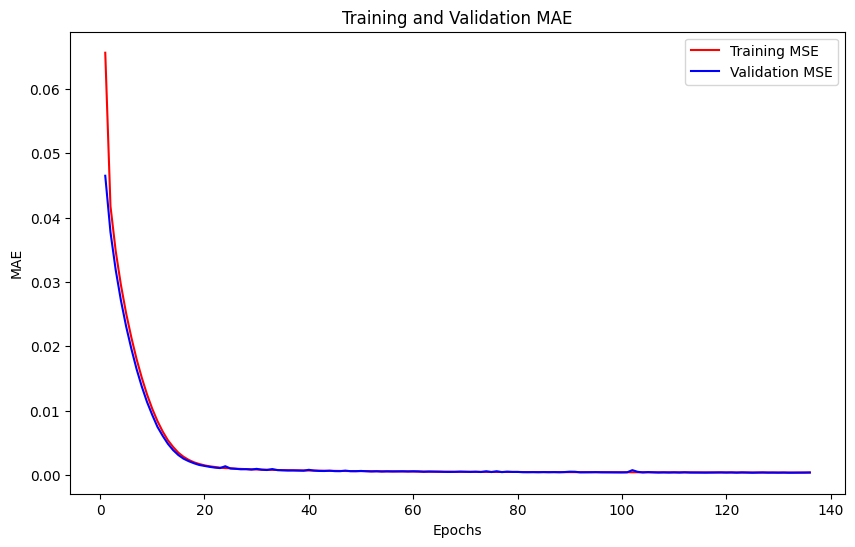

In [15]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

# GridSearch

In [64]:
# def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
#     model = Sequential()
#     model.add(Dense(448, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(384, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(96, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(128, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(320, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(416, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
#     
#     model.add(Dense(416, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
#     
#     model.add(Dense(256, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))    
#     
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
#     return model
# 
# # Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
# model = KerasRegressor(model=build_model, verbose=2)
# 
# # Anpassung der Parameter im param_grid
# param_grid = {
#     'model__learning_rate': [0.01, 0.001, 0.0001],
#     'model__regularization': [0.001, 0.0001],
#     'fit__batch_size': [10, 25, 50, 75],
#     'fit__epochs': [50],
#     'model__dropout_rate' : [0.0, 0.1, 0.2]
# }
# 
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# # Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
# grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# # Beste Parameter und Score ausgeben
# print("Beste Parameter:", grid_search.best_params_)
# print("Beste Genauigkeit:", grid_search.best_score_)
# 
# with open("Gridsearch_D4.txt", "w") as f:
#     f.write(f"Beste Parameter: {grid_search.best_params_}\n")
#     f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


In [16]:
# Funktion zum Erstellen des Modells
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('input_units', min_value=16, max_value=656, step=32), input_shape=(3,), activation='relu'))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=16, max_value=656, step=32), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Durchführung der Random Search dreimal
for run in range(1, 4):
    # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
    directory = 'random_search'
    project_name = f'random_search_D4_t_{run}'
    
    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=100,
        executions_per_trial=2,
        directory=directory,
        project_name=project_name
    )
    
    # Durchführung des Random Search
    tuner.search(X_train_scaled, y_train_scaled, epochs=50, verbose =0, batch_size=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
    
    # Abrufen und Speichern des besten Modells
    best_model = tuner.get_best_models(num_models=1)[0]
    model_path = os.path.join(directory, project_name, 'best_model.h5') 
    best_model.save(model_path)
    

    # Optional: Abrufen und Ausgeben der besten Hyperparameter
    best_hyperparameters = tuner.get_best_hyperparameters()[0]
    
    # Konvertieren der Hyperparameter in ein DataFrame
    df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
    # Speichern des DataFrame als CSV
    df_hyperparameters.to_csv(f'random_search_D4_t_{run}.csv', index=False)
    
    print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")


KeyboardInterrupt: 